In [ ]:
!pip install --quiet transformers
!pip install --quiet emoji
!pip install --quiet imbalanced-learn


#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import emoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 4.1 MB/s eta 0:00:00


In [ ]:
!pip install --quiet clean-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 7.5 MB/s eta 0:00:00


In [ ]:
# Load data

file_path_xlsx = '/content/Data Bully Dimas TI.xlsx'
df = pd.read_excel(file_path_xlsx)

df.head()

,full_text,Label,tweet_url
0,minimal kl gue editin cari materinya lah ajg u...,Bully,https://twitter.com/cook1iejar/status/17057336...
1,jamur ðŸ_x008d_„: ngapain sih ikut becky ke lu...,Bully,https://twitter.com/nindy113/status/1705733387...
2,"@moviemenfes susi saha anjing?? btw galang, sa...",Nobully,https://twitter.com/sluttheryne/status/1705733...
3,Gini amat Jadi Tim Gede pemegang 20 Gelar Liga...,Nobully,https://twitter.com/yourPizzaaaaa/status/17057...
4,@Zaim72790295 @PDI_Perjuangan Lah ini anjing l...,Nobully,https://twitter.com/SzZelo/status/170573330941...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1455 entries, 0 to 1454
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_text  1455 non-null   object
 1   Label      1455 non-null   object
 2   tweet_url  1455 non-null   object
dtypes: object(3)
memory usage: 34.2+ KB


In [ ]:
print(df['Label'].value_counts())

Nobully           1099
Bully              339
Nobully­             4
Nobully_x009d_       2
Nobullly             2
Nobully_x0081_       2
Bully˜               1
Buly                 1
Nobul­ly             1
Nobully˜             1
Bully                1
Nobully_x008d_       1
Bully­               1
Name: Label, dtype: int64


In [ ]:
def clean_label(label):
    label = label.lower()  # Mengubah label menjadi lowercase
    label = re.sub(r'[^\w\s]', '', label)  # Menghapus karakter non-alphanumerik
    label = re.sub(r'\bno+\b', 'nobully', label)  # Menggabungkan 'no' menjadi 'nobully'
    label = re.sub(r'\b(bul+)\b', 'bully', label)  # Menggabungkan 'bul' menjadi 'bully'
    return label

# Membersihkan label pada kolom 'Label'
df['Label'] = df['Label'].apply(clean_label)

In [ ]:
# Mapping label yang akan diubah
label_mapping = {
    'nobullly': 'nobully',
    'buly': 'bully',
    'nobully_x009d_': 'nobully',
    'nobully_x0081_': 'nobully',
    'nobully_x008d_': 'nobully'
}

# Update label sesuai dengan mapping
df['Label'] = df['Label'].replace(label_mapping)

# Mengubah label menjadi lowercase dan menghapus karakter non-alfanumerik
df['Label'] = df['Label'].str.lower().str.replace(r'[^a-zA-Z0-9]', '')

<ipython-input-7-00e56059c40a>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Label'] = df['Label'].str.lower().str.replace(r'[^a-zA-Z0-9]', '')


In [ ]:
print(df['Label'].value_counts())

nobully    1112
bully       343
Name: Label, dtype: int64


In [ ]:
df.drop_duplicates(subset='full_text',inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1414 entries, 0 to 1454
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_text  1414 non-null   object
 1   Label      1414 non-null   object
 2   tweet_url  1414 non-null   object
dtypes: object(3)
memory usage: 44.2+ KB


In [ ]:
df = df[['full_text','Label']]

In [ ]:
import re

def strip_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    text = re.sub(r'@\S+\s?', '', text)  # remove @ and the word after it with the space
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

texts_new = []
for t in df.full_text:
    if isinstance(t, str):  # Periksa apakah tipe data adalah string
        texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))


In [ ]:
print(texts_new)

['minimal kl gue editin cari materinya lah ajg udh di bagi juga tugas per materi malah kaga di cari boro boro di cari pesan ny di read aja kaga babi lo anjing beban bnr ijin misuh y', 'jamur x008d ngapain sih ikut becky ke luar negerimending tiduran di rumah sama aku sambil maen sama anjing kalau kamu pergi pergi terus kapan ada waktu sama aku yaaaaaaangggg', 'susi saha anjing btw galang sampe sekarang juga masih galang', 'gini amat jadi tim gede pemegang 20 gelar liga inggris keliatan banget kali pada syirik nya ke emyu apalagi small club itu makan tuh fakta anjing', 'lah ini anjing lagi ngetweet', 'gak salah sih anjing wkkwkwkwk', 'anjing admin kantor pada dibayarin nonton aespa tottt iri berat', 'tonjok perut dia gw cemburu anjing', 'segala salah submit anjingg anjinggg', 'mau anak anjing pake bangettttttttttt', 'bukan masalah percaya rumor t pi tae pasti baklan date sama cewek ga bakalan sama cowok anjing memang mereka yang tolol ngatain tolol bilang tae dating women tuh langsung p

In [ ]:
for text in texts_new[:1412]:  # Menampilkan 10 sampel pertama
    print(text)

minimal kl gue editin cari materinya lah ajg udh di bagi juga tugas per materi malah kaga di cari boro boro di cari pesan ny di read aja kaga babi lo anjing beban bnr ijin misuh y
jamur x008d ngapain sih ikut becky ke luar negerimending tiduran di rumah sama aku sambil maen sama anjing kalau kamu pergi pergi terus kapan ada waktu sama aku yaaaaaaangggg
susi saha anjing btw galang sampe sekarang juga masih galang
gini amat jadi tim gede pemegang 20 gelar liga inggris keliatan banget kali pada syirik nya ke emyu apalagi small club itu makan tuh fakta anjing
lah ini anjing lagi ngetweet
gak salah sih anjing wkkwkwkwk
anjing admin kantor pada dibayarin nonton aespa tottt iri berat
tonjok perut dia gw cemburu anjing
segala salah submit anjingg anjinggg
mau anak anjing pake bangettttttttttt
bukan masalah percaya rumor t pi tae pasti baklan date sama cewek ga bakalan sama cowok anjing memang mereka yang tolol ngatain tolol bilang tae dating women tuh langsung pada tantrum jekicot dating bongo

In [ ]:
for idx in df.index:
    if idx not in texts_new:
        print(idx, df.loc[idx, 'full_text'])

0 minimal kl gue editin cari materinya lah ajg udh di bagi juga tugas per materi malah kaga di cari, boro boro di cari pesan ny di read aja kaga BABI LO ANJING BEBAN BNR ðŸ˜ƒ ijin misuh y
1 jamur ðŸ_x008d_„: ngapain sih ikut becky ke luar negeri.mending tiduran di rumah sama aku sambil maen sama anjing. kalau kamu pergi pergi terus kapan ada waktu sama aku yaaaaaaangggg ðŸ˜’ðŸ˜’
2 @moviemenfes susi saha anjing?? btw galang, sampe sekarang juga masih galangðŸ˜—
3 Gini amat Jadi Tim Gede pemegang 20 Gelar Liga inggris   Keliatan banget kali Pada syirik nya ke emyu . Apalagi small club" itu  MAKAN TUH FAKTA ANJING https://t.co/fVjhKkfuyN"
4 @Zaim72790295 @PDI_Perjuangan Lah ini anjing lagi ngetweet
5 GAK SALAH SIH ANJING WKKWKWKWK
6 anjing admin kantor pada dibayarin nonton aespa tottt iri berat
7 @menfesspelangi_ Tonjok perut dia = gw cemburu anjing
8 segala salah submit anjingg anjinggg
9 MAU ANAK ANJING PAKE BANGETTTTTTTTTTT
10 @anggvr Bukan masalah percaya rumor t Pi Tae pasti baklan 

In [ ]:
# Mencari indeks yang tidak ada di 'texts_new'
missing_indices = [i for i in range(len(df)) if i not in range(len(texts_new))]

# Menghapus baris dengan indeks yang tidak ada di 'texts_new'
df = df.drop(missing_indices)

# Mengubah kolom 'text_clean' dengan 'texts_new'
df['text_clean'] = texts_new
df['text_clean'].head()

0    minimal kl gue editin cari materinya lah ajg u...
1    jamur x008d ngapain sih ikut becky ke luar neg...
2    susi saha anjing btw galang sampe sekarang jug...
3    gini amat jadi tim gede pemegang 20 gelar liga...
4                         lah ini anjing lagi ngetweet
Name: text_clean, dtype: object

In [ ]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

df['text_len'] = text_len

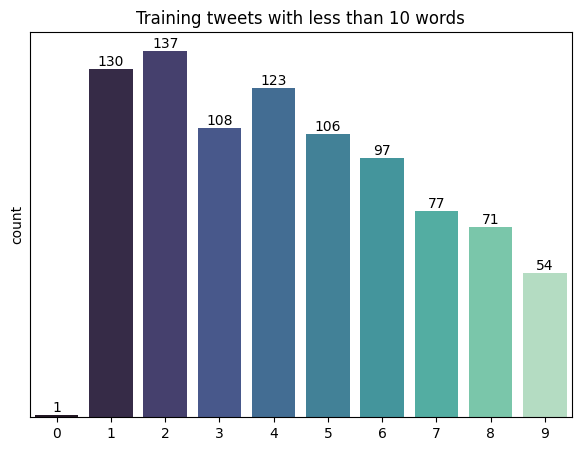

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [ ]:
print(f" DF SHAPE: {df.shape}")

 DF SHAPE: (1412, 4)


In [ ]:
df = df[df['text_len'] > 3]
print(f" DF SHAPE: {df.shape}")

 DF SHAPE: (1036, 4)


In [ ]:

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)

print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 127


In [ ]:
df['Label'].value_counts()

nobully    822
bully      214
Name: Label, dtype: int64

In [ ]:
df['Label'] = df['Label'].map({'nobully':0,'bully':1})
df['Label'].value_counts()

0    822
1    214
Name: Label, dtype: int64

In [ ]:
ros = RandomOverSampler()
x, y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Label']).reshape(-1, 1));
os = pd.DataFrame(list(zip([x[0] for x in x], y)), columns = ['text_clean', 'Label']);

In [ ]:
os['Label'].value_counts()

1    822
0    822
Name: Label, dtype: int64

In [ ]:
x, y = os['text_clean'].values, os['Label'].values
x_train, x_valid, y_train, y_valid = train_test_split(x, y,
                                                      stratify = y,
                                                      random_state = 40,
                                                      test_size = 0.1,
                                                      shuffle = True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_valid = le.transform(y_valid)

In [ ]:
MAX_LEN=128

def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
train_input_ids, train_attention_masks = tokenize(x_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(x_valid, MAX_LEN)

In [ ]:
def create_model(bert_model, max_len=MAX_LEN):

    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.BinaryCrossentropy()
    accuracy = tf.keras.metrics.BinaryAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')

    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')

    embeddings = bert_model([input_ids,attention_masks])[1]

    output = tf.keras.layers.Dense(1, activation="sigmoid")(embeddings)

    # Gunakan nama yang berbeda untuk model yang akan dikembalikan
    model_out = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)

    # Gunakan metrics=['accuracy'] dalam model.compile
    model_out.compile(opt, loss=loss, metrics=[accuracy])

    return model_out

In [ ]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

In [ ]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=10, batch_size=42)

Epoch 1/10
36/36 [==============================] - 87s 1s/step - loss: 0.6882 - binary_accuracy: 0.5497 - val_loss: 0.6647 - val_binary_accuracy: 0.5879
Epoch 2/10
36/36 [==============================] - 35s 965ms/step - loss: 0.6142 - binary_accuracy: 0.6579 - val_loss: 0.5544 - val_binary_accuracy: 0.7394
Epoch 3/10
36/36 [==============================] - 36s 1s/step - loss: 0.4509 - binary_accuracy: 0.7992 - val_loss: 0.4665 - val_binary_accuracy: 0.7939
Epoch 4/10
36/36 [==============================] - 36s 1s/step - loss: 0.3342 - binary_accuracy: 0.8715 - val_loss: 0.3268 - val_binary_accuracy: 0.8667
Epoch 5/10
36/36 [==============================] - 38s 1s/step - loss: 0.1943 - binary_accuracy: 0.9371 - val_loss: 0.3254 - val_binary_accuracy: 0.9091
Epoch 6/10
36/36 [==============================] - 38s 1s/step - loss: 0.1167 - binary_accuracy: 0.9709 - val_loss: 0.1907 - val_binary_accuracy: 0.9455
Epoch 7/10
36/36 [==============================] - 38s 1s/step - loss: 0

In [ ]:
# Prediksi dan confusion matrix
result_bert = model.predict([val_input_ids, val_attention_masks])
y_pred_bert = np.round(result_bert).astype(int)

6/6 [==============================] - 1s 229ms/step


In [ ]:
#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

# Confusion matrix
conf_matrix = confusion_matrix(y_valid, y_pred_bert)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
classification_rep = classification_report(y_valid, y_pred_bert)
print("\nClassification Report:")
print(classification_rep)


Confusion Matrix:
[[72 11]
 [ 1 81]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.87      0.92        83
           1       0.88      0.99      0.93        82

    accuracy                           0.93       165
   macro avg       0.93      0.93      0.93       165
weighted avg       0.93      0.93      0.93       165



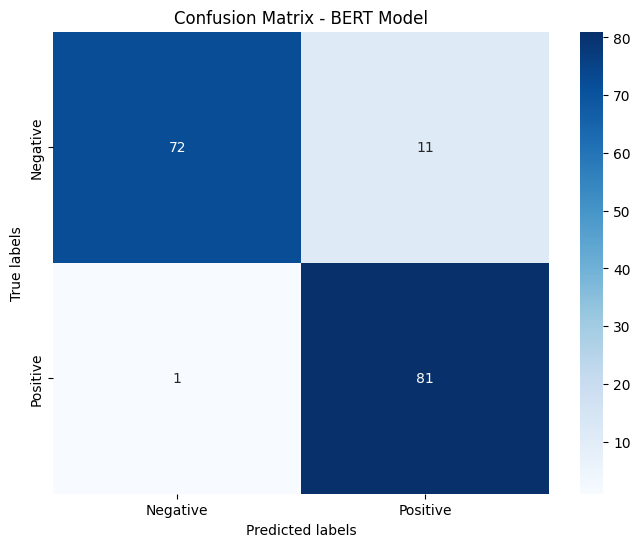

In [ ]:
# Membuat confusion matrix dalam bentuk grafik
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()

# Labels yang sesuai dengan data Anda
class_names = ['Negative', 'Positive']

# Memanggil fungsi plot_confusion_matrix
plot_confusion_matrix(y_valid, y_pred_bert, classes=class_names, title='Confusion Matrix - BERT Model')